# Final Project 

In this project, we will focus on analyzing the Airbnb dataset to extract desired insights from the dataset

# Table of Contents 

## 1. Problem Framing
## 2. Data Preprocessing 
## 3. Modeling
## 4. Conclusion

# I. Problem Framing 

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from  ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import tree

# II. Data Preprocessing


In [ ]:
df = pd.read_csv('airbnb_listings_austin.csv')

# pandas profiling
# profile = ProfileReport(df, title='Raw Data Report', explorative=True)
# profile.to_file("airbnb_listing_austin.html")

## 1. Drop Columns

In [105]:
# Drop columns that add no value to our analysis 
worthless_col = ['experiences_offered',
                 'host_listings_count', 
                 'listing_url', 
                 'name', 
                 'host_name', 
                 'has_availability', 
                 'listing_url', 
                 'space',
                 'notes',
                 'transit',
                 'host_name',
                 'host_location',
                 'host_response_rate',
                 'host_has_profile_pic',
                 'square_feet',
                 'city',
                 'neighborhood_overview',
                 'host_response_time',
                 'summary',
                 'beds'
                 ]

missing_val_col = ['host_about', 
                   'neighbourhood',
                   'weekly_price',
                   'review_scores_accuracy', 
                   'review_scores_cleanliness', 
                   'review_scores_checkin',
                   'review_scores_communication',
                   'review_scores_location',
                   'review_scores_value',
                   'availability_365']

drop_col = worthless_col + missing_val_col 

df.drop(drop_col, axis=1, inplace=True)

## 2. Outliers Treatment 

Extreme values weill be replaced by the upper bound and lower bound

In [106]:
def winsorize_series(s):
    s = s.copy()
    IQR = s.quantile(0.75) - s.quantile(0.25)
    Q_1 = s.quantile(0.25)
    Q_3 = s.quantile(0.75)
    upper_bound = Q_3 + 1.5 * IQR
    lower_bound = Q_1 - 1.5 * IQR
    s[s > upper_bound] = upper_bound
    s[s < lower_bound] = lower_bound
    return s


In [107]:
# count the number of numeric columns in the dataset 
outlier_fixed = df.select_dtypes(include=['int64', 'float64']).columns

# remove id an dhost_id from the list
outlier_fixed = outlier_fixed.drop(['id', 'host_id'])

# winsorize the outliers
for col in outlier_fixed:
    df[col] = winsorize_series(df[col])

## 3. Missing Values

Categorical Features: for features with a few missing values (typically less than 10%), we replace these NAs by the dominant level in the feature. 

In [108]:
# replace categorical missing values with the class majority
def replace_missing_cat(df, col):
    """
    Replace missing values in categorical columns with the class majority
    """
    return df[col].fillna(df[col].mode()[0], inplace=True)

missing_val_col = ['host_is_superhost', 'host_identity_verified']
# replace missing values in categorical columns
for col in missing_val_col:
    replace_missing_cat(df, col)


Numeric features: 
- for security_deposit and cleaning_fee, we will replace missing values with 0

In [109]:
df['security_deposit'].fillna(0, inplace=True)
df['cleaning_fee'].fillna(0, inplace=True)


- for host_since, bathrooms, bedrooms, beds, I replace NAs by the median

In [110]:
# Convert 'host_since' column to datetime, extract year only
df['host_since'] = pd.to_datetime(df['host_since']).dt.year
# Replace missing values with the median
df['host_since'].fillna(df['host_since'].median(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace=True)

Text features

- for missing values in the summary column, replace them with ''. Later on we would count the number of words in the summary column to create another column (in the feature engineering step)

In [111]:
# replace missing values in summary by '' 
df['description'].fillna('', inplace=True)

In [112]:
# check for missing values
df.isnull().sum()

id                        0
description               0
host_id                   0
host_since                0
host_is_superhost         0
host_identity_verified    0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
bed_type                  0
amenities                 0
price                     0
security_deposit          0
cleaning_fee              0
guests_included           0
extra_people              0
minimum_nights            0
availability_30           0
availability_60           0
availability_90           0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
cancellation_policy       0
dtype: int64

## 4. Feature Engineering

Convert host_since to yrs_since_host 

In [113]:
# Convert host_since to yrs_since_host 
df['yrs_since_host'] = 2023 - df['host_since']
df.drop('host_since', axis=1, inplace=True)

Count the number of words in summary and neighborhood 

In [114]:
# Count the number of words in summary 
df['description'] = df['description'].str.split().str.len()

Convert price to int

In [115]:
def remove_dollar_sign(df, col):
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype(float)
    return df[col]
# turn this into a function 
df['price']  = remove_dollar_sign(df, 'price')
df['security_deposit'] = remove_dollar_sign(df, 'security_deposit')
df['cleaning_fee'] = remove_dollar_sign(df, 'cleaning_fee')
df['extra_people'] = remove_dollar_sign(df, 'extra_people')

# fill some NAs again
df['security_deposit'].fillna(0, inplace=True)
df['cleaning_fee'].fillna(0, inplace=True)


C:\Users\brian\AppData\Local\Temp\ipykernel_30544\1596116723.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '')


Convert cancellation_policy to an ordinal variable:
- flexible: 0
- moderate: 1
- strict: 2
- super_strict: 3
- no_refunds: 4

In [116]:
# Convert cancellation_policy to an ordinal variable:

df['cancellation_policy'] = df['cancellation_policy'].map({'flexible': 0,
                                                              'moderate': 1,
                                                              'strict': 2,
                                                              'super_strict_30': 3,
                                                              'super_strict_60': 3,
                                                              'no_refunds': 4})


Create a high rating variable based on the Q1 of review_scores_rating. So if the rating is greater than Q1, it is classified as high rating

In [117]:
df['high_rating'] = np.where(df['review_scores_rating'] > df['review_scores_rating'].quantile(0.25), 1, 0)

Count the number of amenities

In [118]:
df['amenities'] = df['amenities'].str.split(',').str.len()

In the property_type, convert it to property_type_House, property_type_Apartment, property_type_Other

In [119]:
for i in df['property_type']:
    if i not in ['House', 'Apartment']:
        df['property_type'] = df['property_type'].replace(i, 'Other')

# Convert property_type to dummy variables
df = pd.get_dummies(df, columns=['property_type'], drop_first=True)

In the bed_type, retain real bed level only, convert the rest to Other

In [120]:
df['bed_type'] = [i.replace(' ', '_') for i in df['bed_type']]

for i in df['bed_type']:
    if i not in ['Real_Bed']:
        df['bed_type'] = df['bed_type'].replace(i, 'Other')

# Convert property_type to dummy variables
df = pd.get_dummies(df, columns=['bed_type'], drop_first=True)

Convert room_type to dummy variables 

In [121]:
# Convert room_type to dummy variables 
df = pd.get_dummies(df, columns=['room_type'], drop_first=True)

Convert boolean variables to dummy variable 

In [122]:
df['instant_bookable'] = df['instant_bookable'].map({'f': 0, 't': 1})
df['host_is_superhost'] = df['host_is_superhost'].map({'f': 0, 't': 1})
df['host_identity_verified'] = df['host_identity_verified'].map({'f': 0, 't': 1})
df['property_type_House'] = df['property_type_House']*1
df['property_type_Other'] = df['property_type_Other']*1
df['room_type_Private_room'] = df['room_type_Private room']*1
df['room_type_Shared_room'] = df['room_type_Shared room']*1
df['bed_type_Real_Bed'] = df['bed_type_Real_Bed']*1
df.drop(['room_type_Private room', 'room_type_Shared room'], axis=1, inplace=True)


In [123]:
# figure out what features are not binary

binary_features = ['host_is_superhost', 
                   'host_identity_verified', 
                   'instant_bookable', 
                   'property_type_House', 
                   'property_type_Other', 
                   'room_type_Private_room',
                   'room_type_Shared_room', 
                   'bed_type_Real_Bed', 
                   'high_rating']

id_features = ['id', 'host_id']

# Correlation Analysis 

Here, we are going to conduct a correlation analysis in order to identify the relationship between selected variables. 

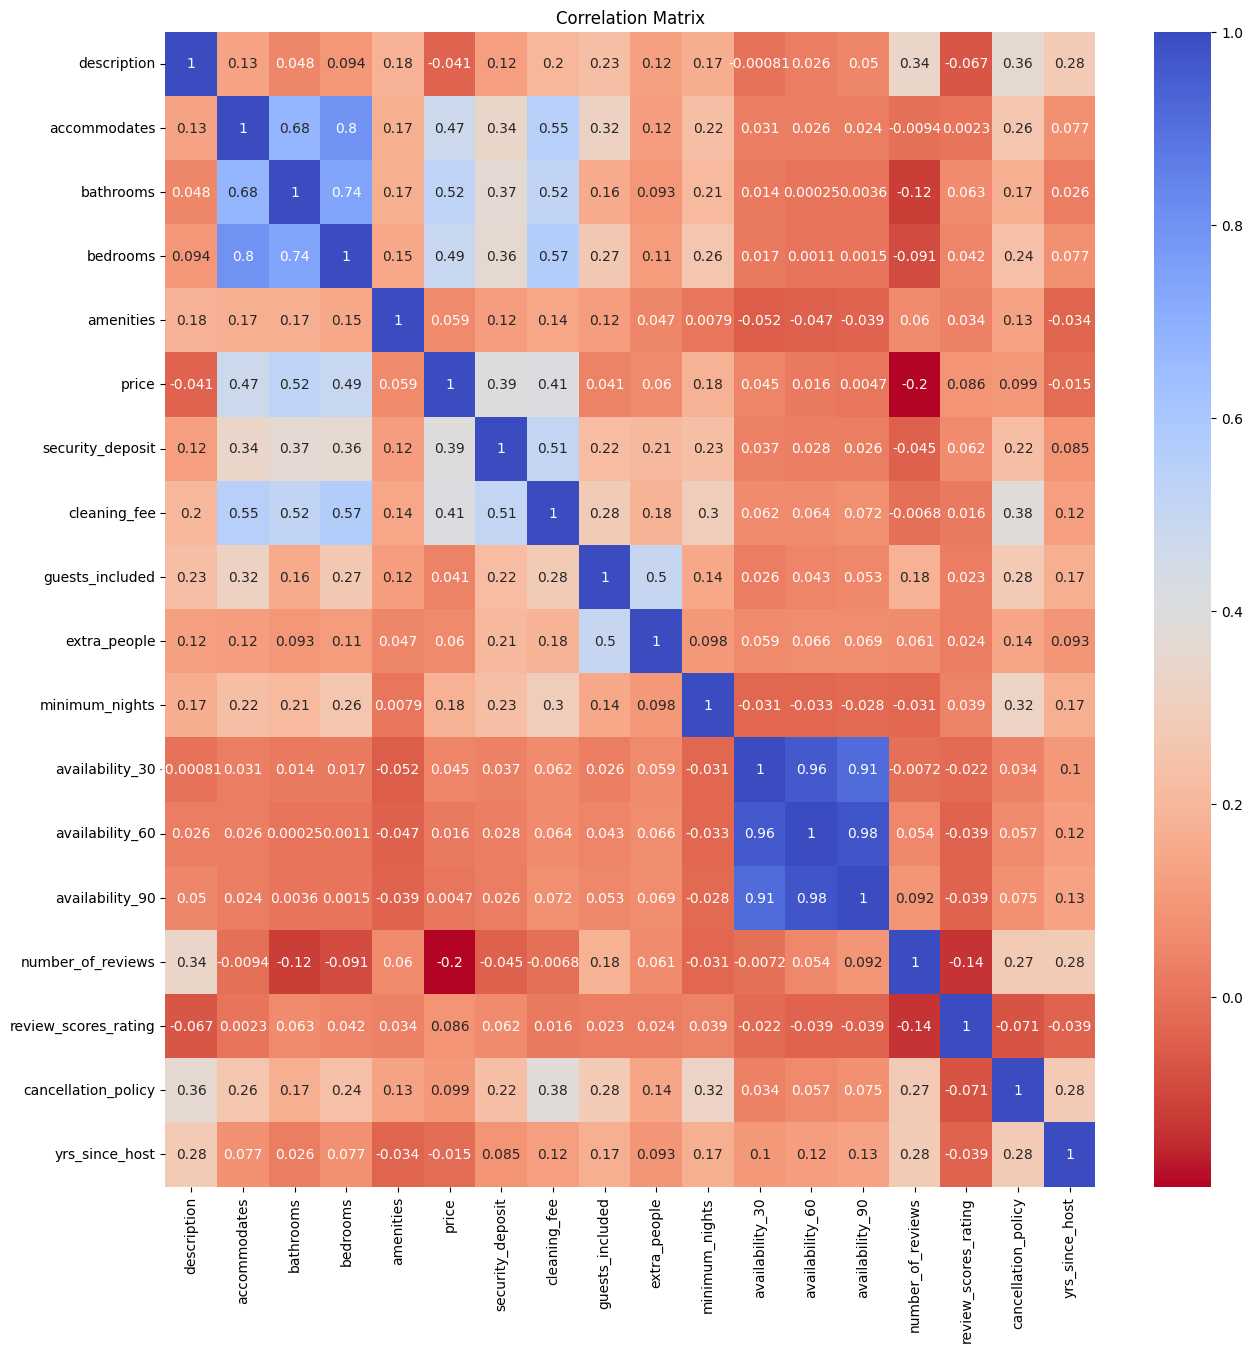

In [124]:
# Create a list of variables that we are going to use in the correlation matrix 
cor_list = [i for i in df.columns if (i not in binary_features) and (i not in id_features)]

# create a correlation matrix
corr = df[cor_list].corr()
# plot the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm_r')
plt.title('Correlation Matrix')
plt.show()


Based on the correlation graph, it seems that accommodates, bathrooms, and bedrooms are highly correlated with one another. I decide to keep bedrooms only because it makes the most sense from a business perspective 

In [125]:
df.drop(['bathrooms', 'accommodates'], axis = 1, inplace = True)
cor_list.remove('bathrooms')
cor_list.remove('accommodates')
cor_list.remove('price')

Now the dataset should be ready for conducting analysis

# III. Modeling 

## Question 1: What are the key factors driving the nightly rental price for units in the Austin area?

In [126]:
price = df['price']

In [127]:
# list all the features that are going to be used in our 
x = df[cor_list+binary_features]

# reshape the target variable
y = df['price'].values.reshape(-1, 1)

In [128]:
# add a constant to the independent variables
x = sm.add_constant(x)

# fit the model on the data
model = sm.OLS(y, x)
results = model.fit()

# print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     130.7
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:01:53   Log-Likelihood:                -42026.
No. Observations:                5835   AIC:                         8.410e+04
Df Residuals:                    5810   BIC:                         8.427e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    187

To check if any variables are not useful, we run the VIF function 

In [129]:
# calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns

print(vif)

     VIF Factor                features
0   1404.478127                   const
1      1.362996             description
2      2.125011                bedrooms
3      1.125380               amenities
4      1.409283        security_deposit
5      1.958666            cleaning_fee
6      1.555133         guests_included
7      1.368733            extra_people
8      1.253110          minimum_nights
9     14.212325         availability_30
10    47.728086         availability_60
11    24.247010         availability_90
12     1.919112       number_of_reviews
13     3.014745    review_scores_rating
14     1.522489     cancellation_policy
15     1.238648          yrs_since_host
16     1.425775       host_is_superhost
17     1.140443  host_identity_verified
18     1.034453        instant_bookable
19     1.656914     property_type_House
20     1.164773     property_type_Other
21     1.636841  room_type_Private_room
22     1.182539   room_type_Shared_room
23     1.140319       bed_type_Real_Bed


It seems that availability_60 and availability_90 are not useful, we would remove them from our model iteratively 

In [130]:
x_filter = x.drop(['availability_90', 'availability_60'], axis = 1)

In [131]:
# calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_filter.values, i) for i in range(x_filter.shape[1])]
vif["features"] = x_filter.columns

print(vif)

     VIF Factor                features
0   1402.920156                   const
1      1.361905             description
2      2.120344                bedrooms
3      1.125351               amenities
4      1.407831        security_deposit
5      1.954059            cleaning_fee
6      1.554345         guests_included
7      1.368647            extra_people
8      1.252955          minimum_nights
9      1.059516         availability_30
10     1.876608       number_of_reviews
11     3.013776    review_scores_rating
12     1.521781     cancellation_policy
13     1.238355          yrs_since_host
14     1.425592       host_is_superhost
15     1.139230  host_identity_verified
16     1.033674        instant_bookable
17     1.654010     property_type_House
18     1.163078     property_type_Other
19     1.634033  room_type_Private_room
20     1.181250   room_type_Shared_room
21     1.140218       bed_type_Real_Bed
22     3.451578             high_rating


Now rerun the linear regression model with the new set of features. 

In [132]:
# fit the model on the data
model = sm.OLS(y, x_filter)
results = model.fit()

# print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     141.9
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:01:53   Log-Likelihood:                -42032.
No. Observations:                5835   AIC:                         8.411e+04
Df Residuals:                    5812   BIC:                         8.426e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    173

The linear regression model can help explain roughly 35% variability in the price of an Airbnb

Investigating on some statistical significant features, which could be considered as driving factor for the rental price. 

Positive impact: bedrooms, number of review, room_type_Private_room, high_rating

Negative impact: guest_included, room_type_Private_room, yrs_since_host

# Question 2: What are the key factors driving the probabiliy of keeping a unit bookoed in the Austin area? 

To answer this question, there are two main task that I need to accomplish:
- Create the column unit_booked 
- Produce box plot to observe the relationship between unit_booked and other features and pivot table 

In [133]:
# Createa a a unit_booked column. If the the availability_90 is less than 40%, then it is booked

df['unit_booked'] = np.where(df['availability_90'] < 90*0.4, 1, 0)

# convert to string

df['unit_booked'] = df['unit_booked'].astype(str)

# get all the numeric variables to visualize the barplot
num_col = cor_list.copy()
num_col.remove('availability_30')
num_col.remove('availability_60')
num_col.remove('availability_90')


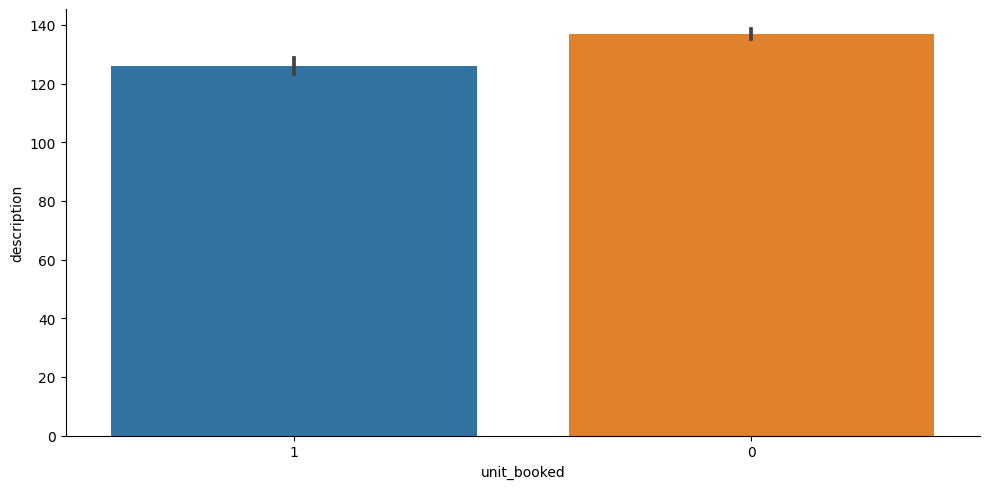

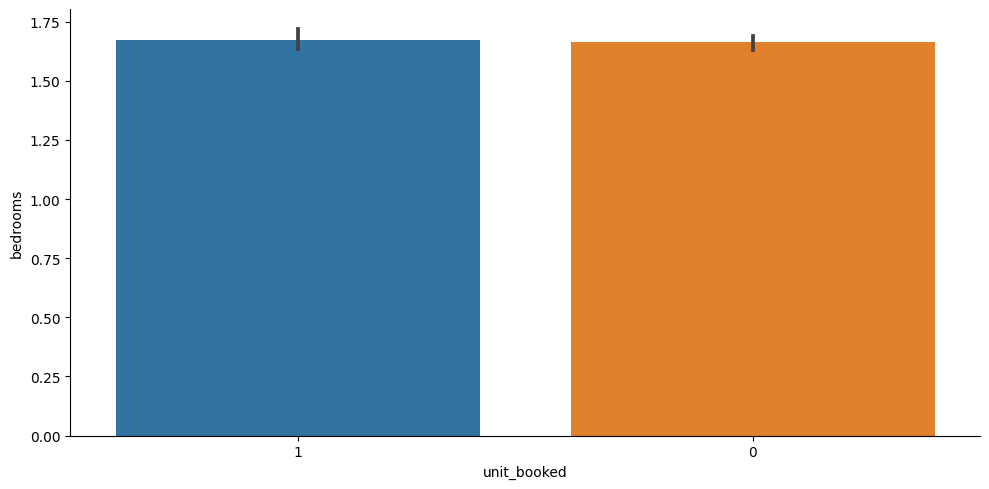

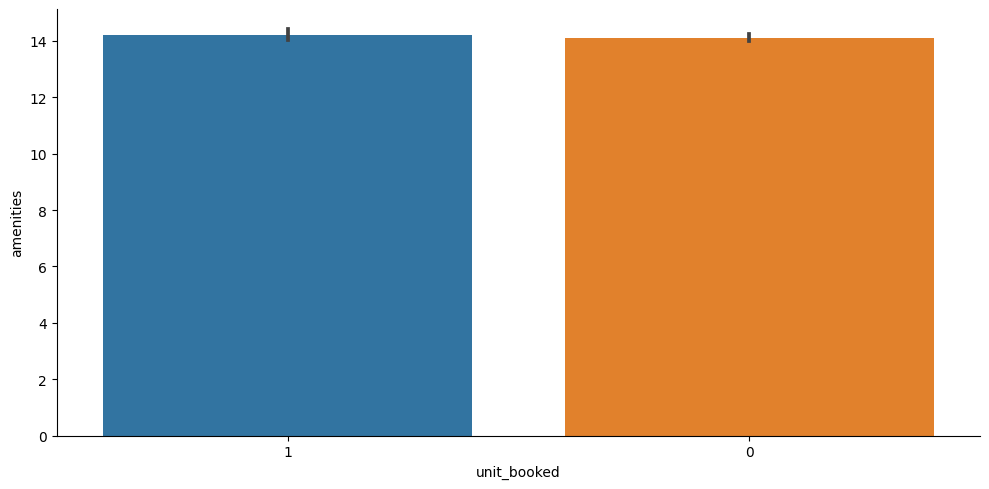

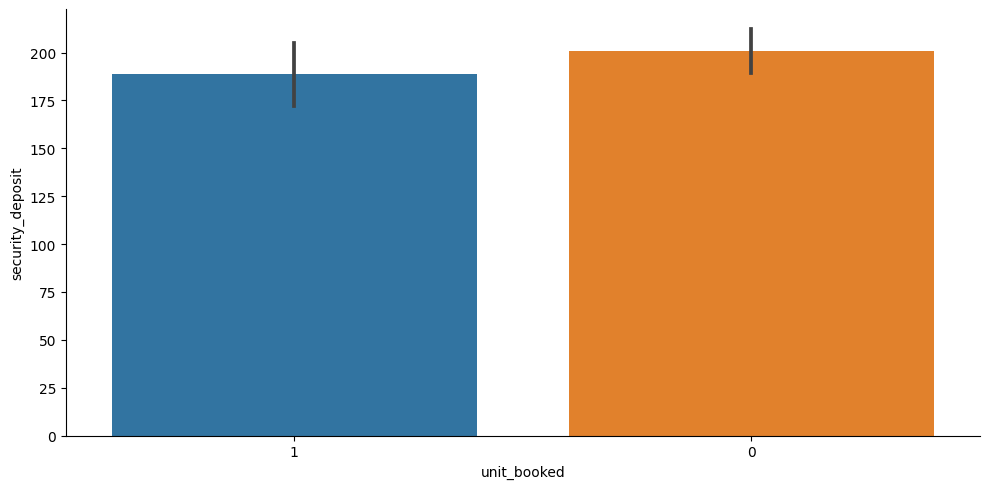

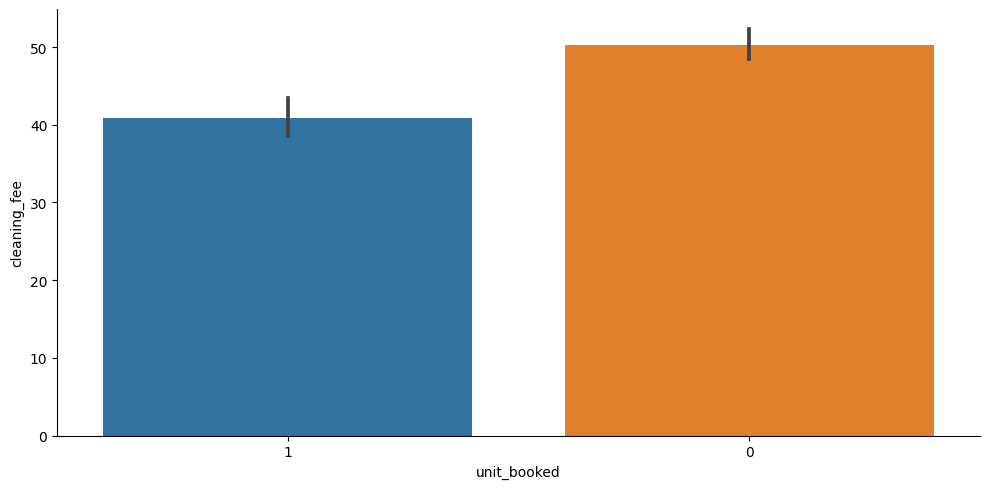

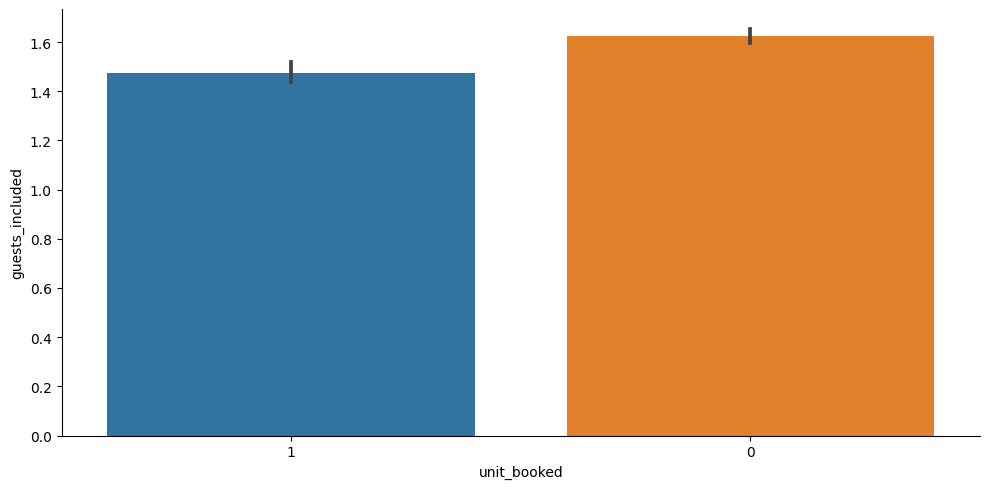

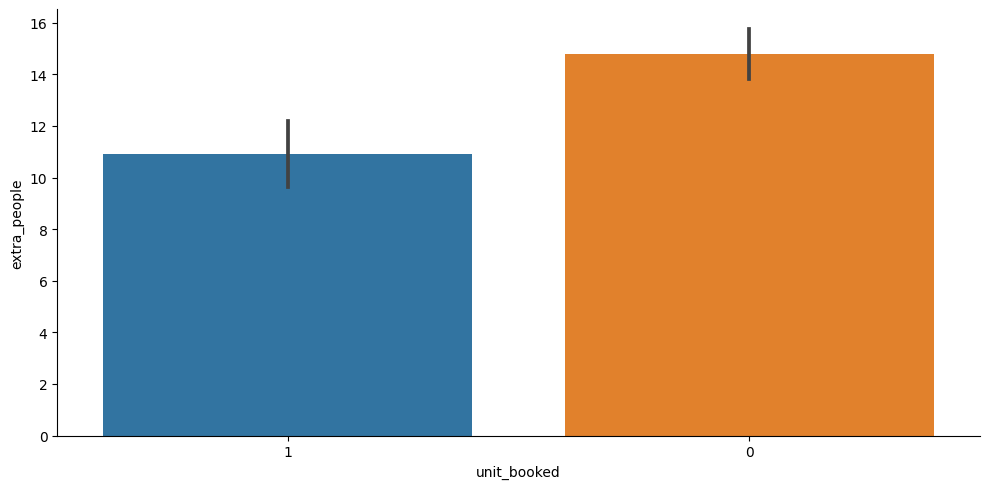

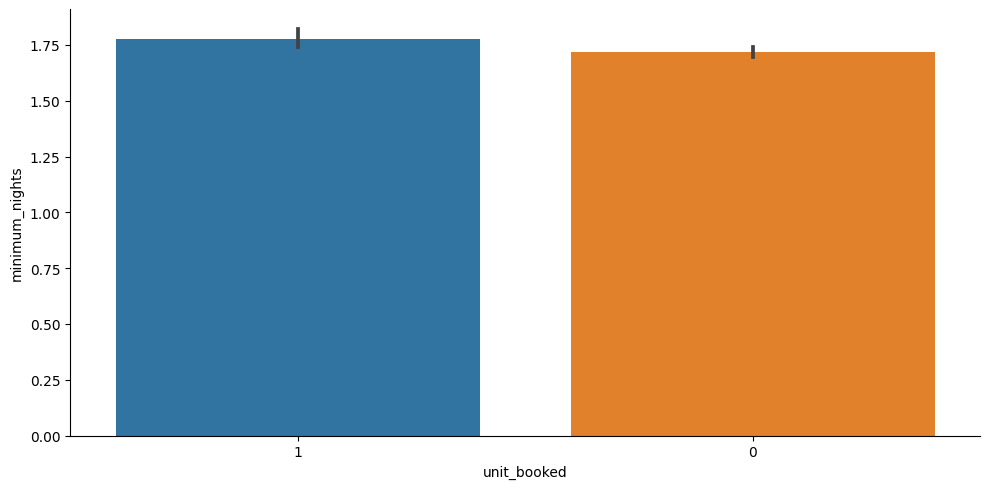

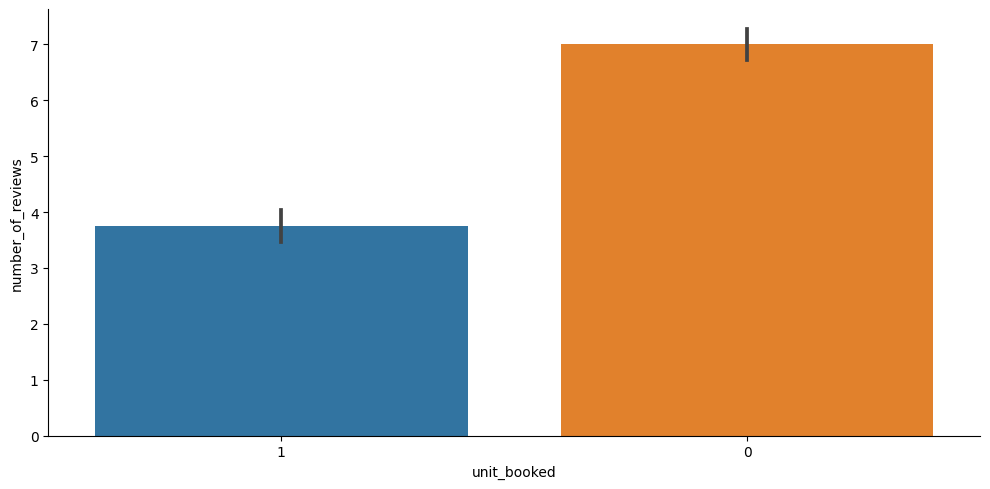

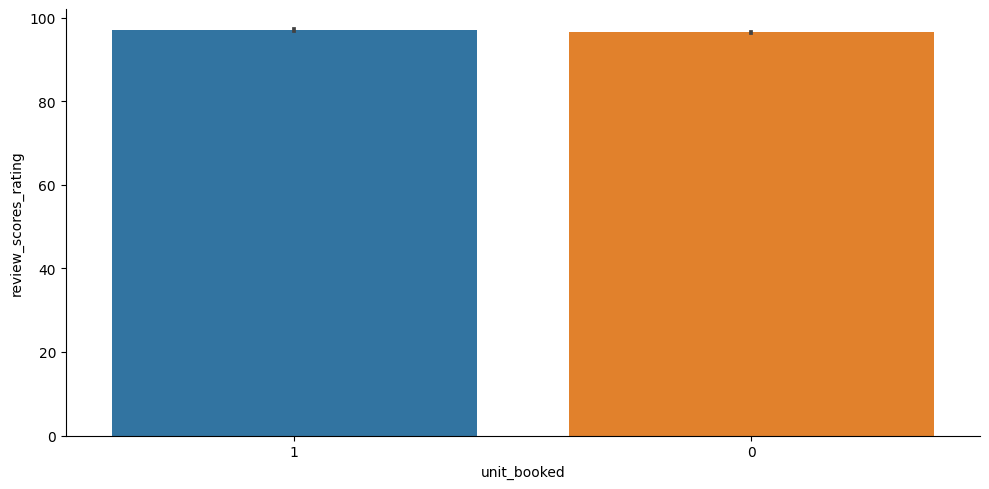

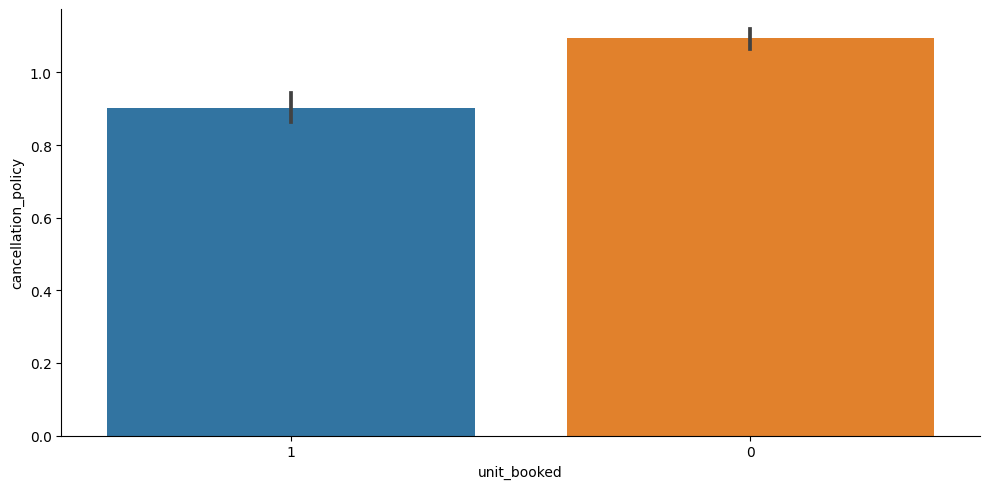

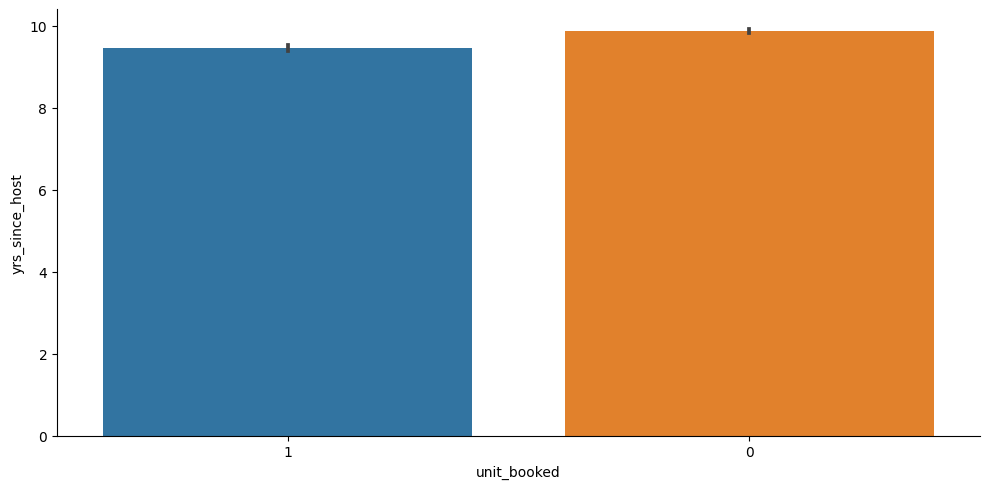

In [134]:
for i in num_col:
    sns.catplot(x='unit_booked', y=i, data=df, kind='bar', height=5, aspect=2)
    plt.show()

unit_booked               0         1
host_is_superhost                    
0                  0.839525  0.899833
1                  0.160475  0.100167


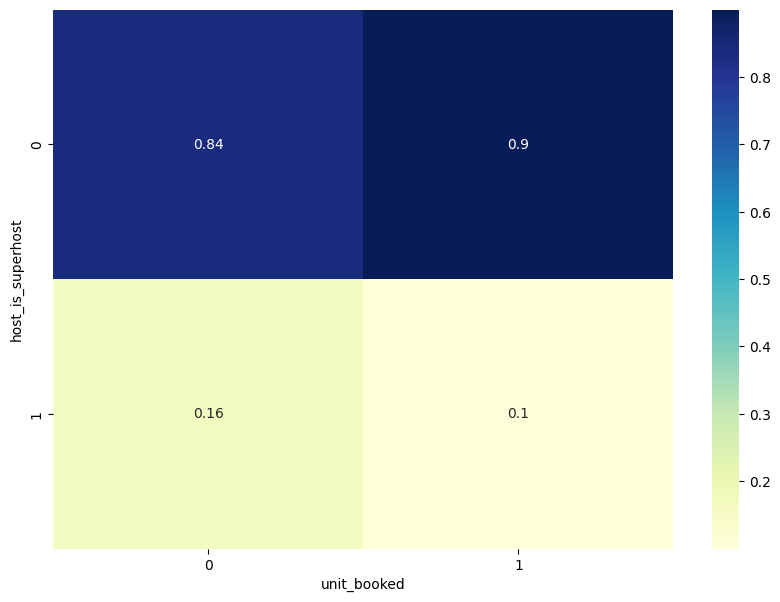



unit_booked                    0         1
host_identity_verified                    
0                       0.310302  0.357819
1                       0.689698  0.642181


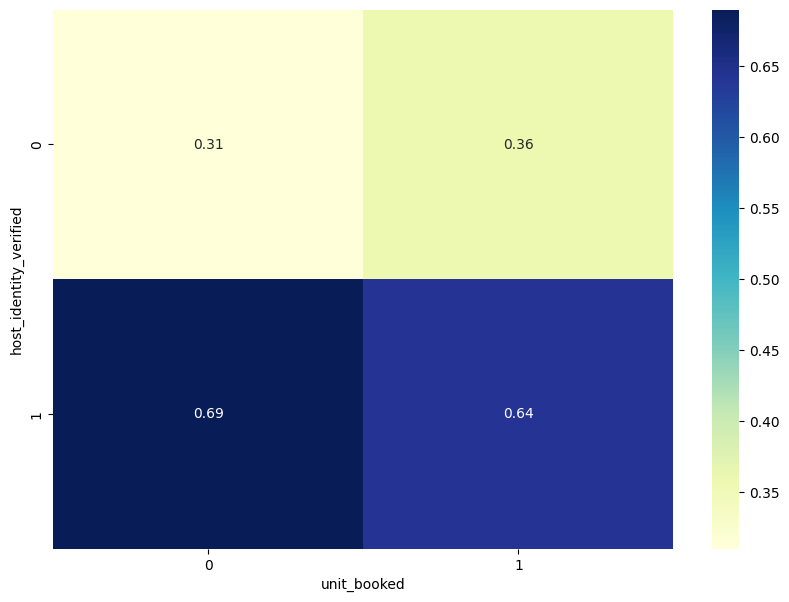



unit_booked              0         1
instant_bookable                    
0                 0.906142  0.919866
1                 0.093858  0.080134


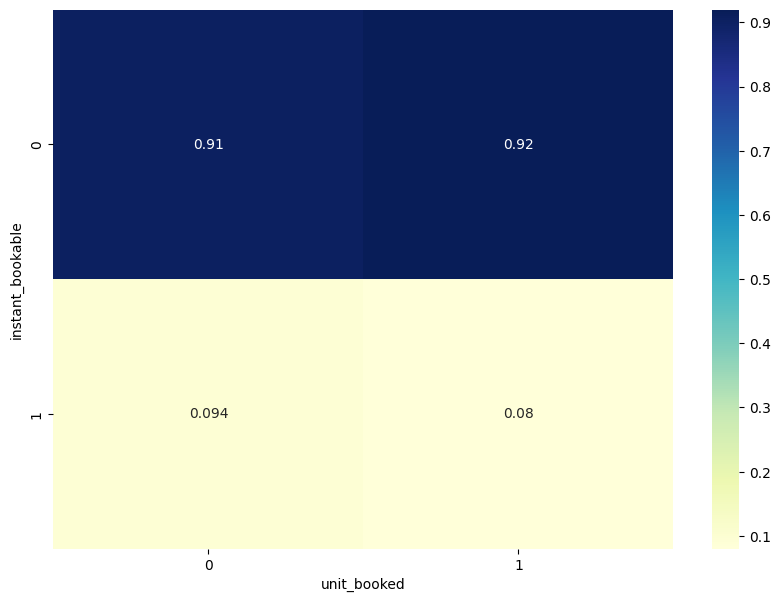



unit_booked                0         1
property_type_House                   
0                    0.35785  0.467446
1                    0.64215  0.532554


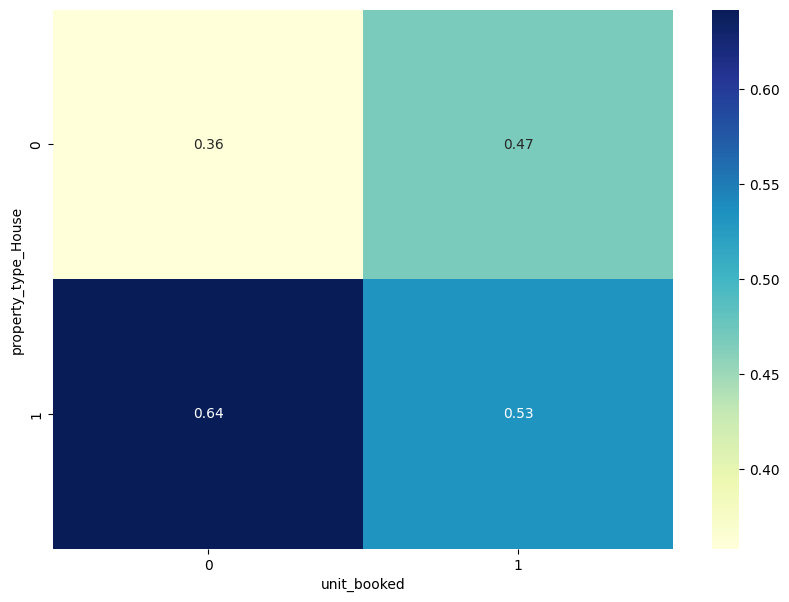



unit_booked                 0         1
property_type_Other                    
0                    0.923725  0.932109
1                    0.076275  0.067891


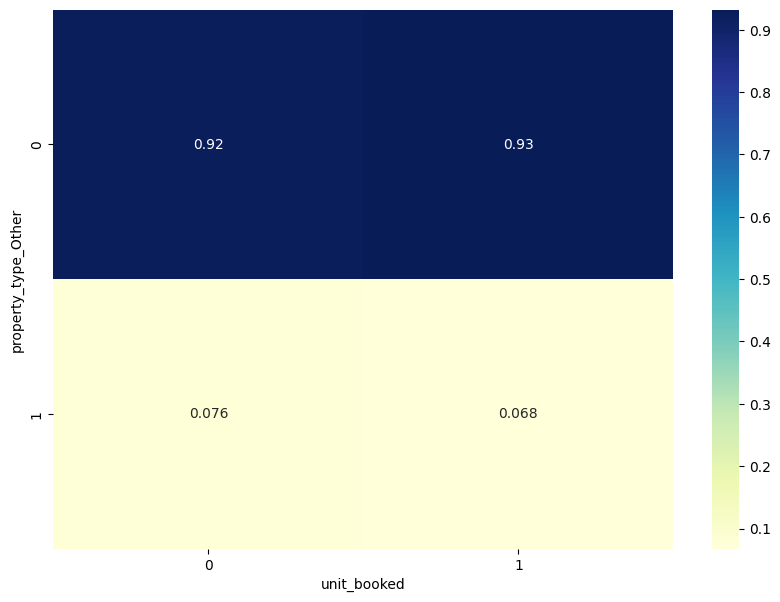



unit_booked                   0        1
room_type_Private_room                  
0                       0.68945  0.77852
1                       0.31055  0.22148


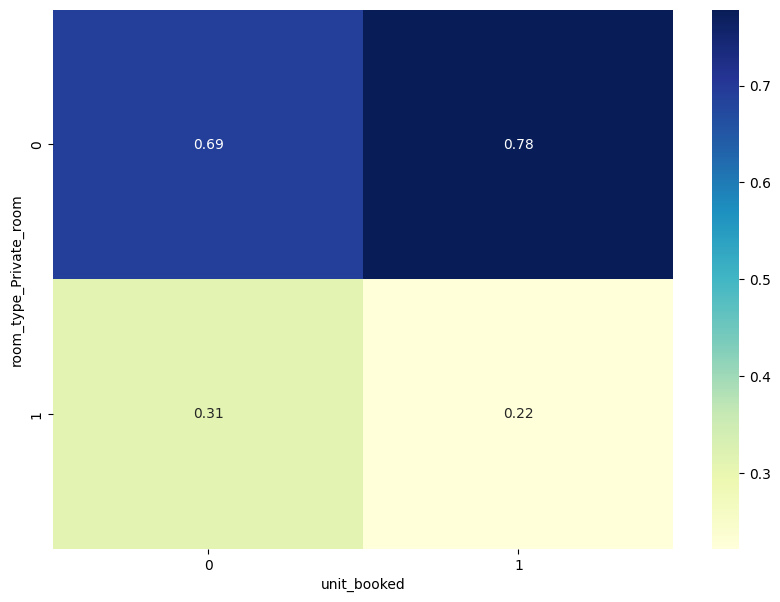



unit_booked                   0         1
room_type_Shared_room                    
0                      0.976474  0.984418
1                      0.023526  0.015582


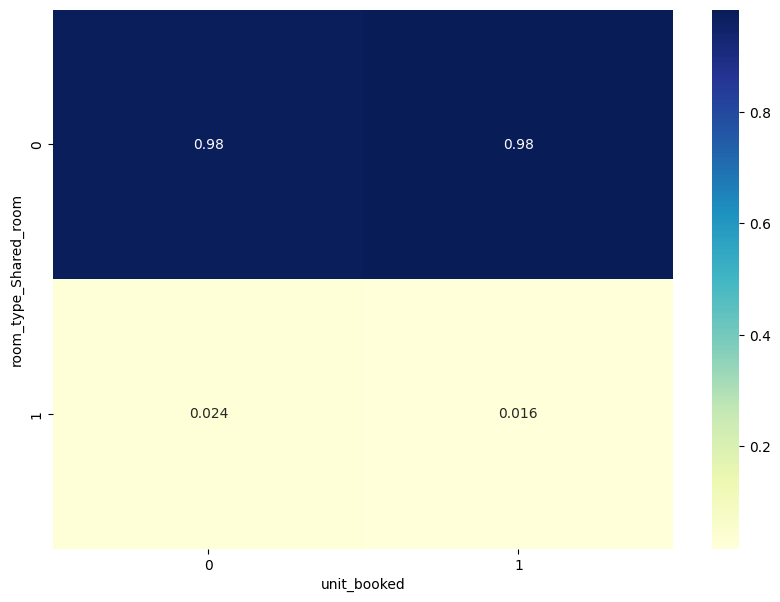



unit_booked               0         1
bed_type_Real_Bed                    
0                  0.038138  0.026711
1                  0.961862  0.973289


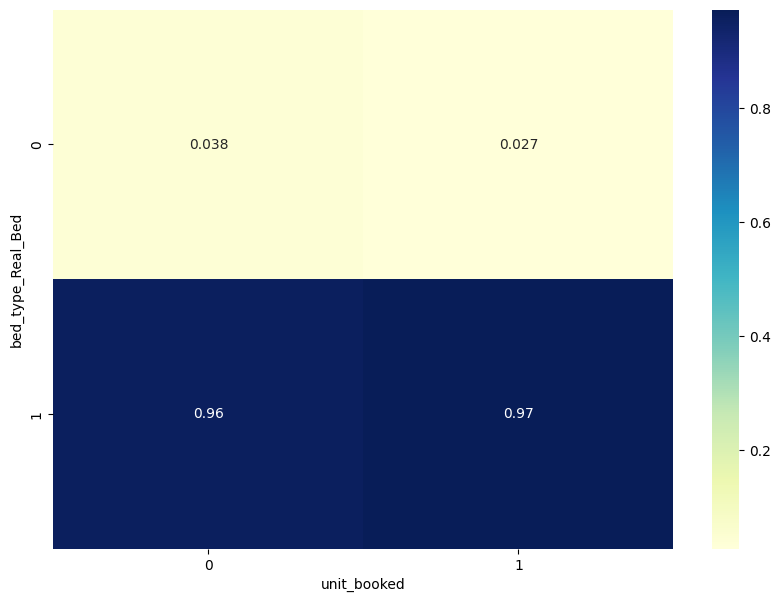



unit_booked         0         1
high_rating                    
0            0.286776  0.193656
1            0.713224  0.806344


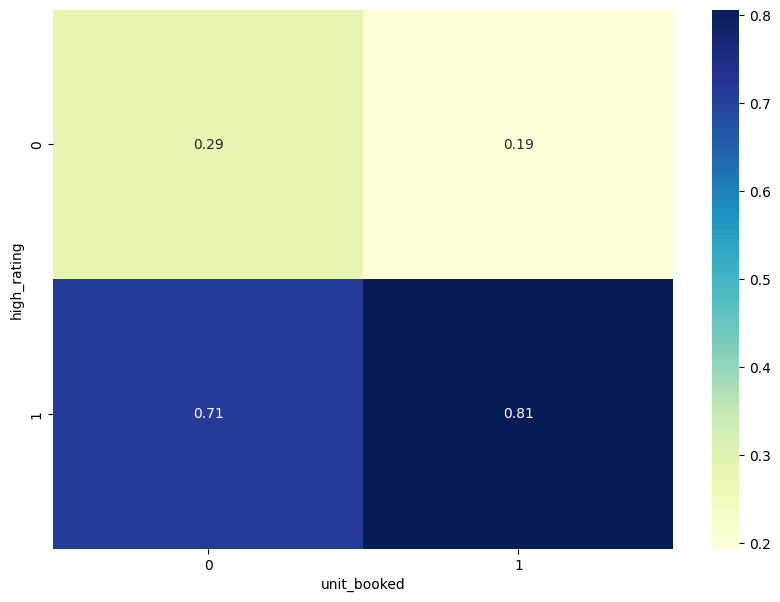

In [135]:
# use pd.crosstab to see the relationship between unit_booked and all binary variable
for i in binary_features:
    cross_tab = pd.crosstab(df[i], df['unit_booked'], normalize='columns')
    print(cross_tab)
    # plot the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
    plt.show() 
    print('\n')


What are the key factors driving the probabiliy of keeping a unit bookoed in the Austin area? 

- Lower cleaning fee, lower the cost for having extra people,easier cancellation policy
- Real bed, host identity is verified, the majoity of these properties have high rating

### Question 3:  How important are guest review and ratings? Is there anything the host could do to improve those ratings? 

To address this problem, at first, I will visualize the box plot to observe the relationship between the price and the rating. Next, I will build a classification tree where high_rating serves as a the label. Again, 1 represents high rating and 0 is low score rating. From model outcomes, I would be able to extract the feature importance, and see what interactions between features can lead to high rating 

In [136]:
x.drop(['const'], axis=1, inplace=True)
df = df.drop(['id', 'host_id'], axis=1)
x = df.drop(['price'], axis=1)
y = x['high_rating']
x = x.drop(['high_rating'], axis=1)
x = x.drop(['review_scores_rating'], axis=1)

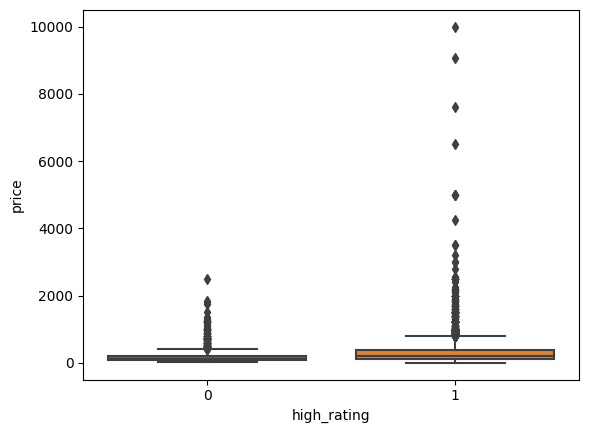

In [138]:
# visualize the relationship between high_rating and and the price using boxplot

sns.boxplot(x='high_rating', y='price', data=df)
plt.show()

It's quite hard to see the relationship, so I decide to take a square root of the price 

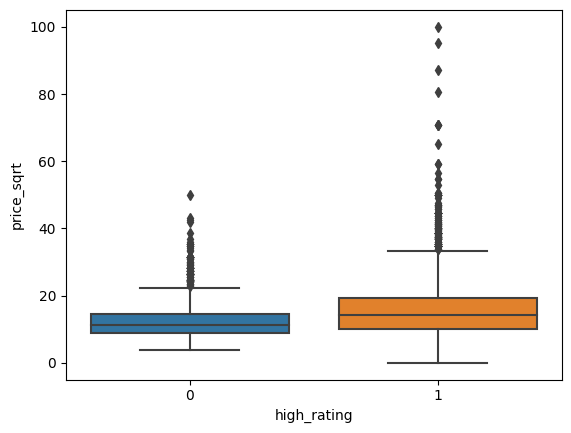

In [139]:
# It's quite hard to see the relationship, so I decide to take a square root of the price 
# to make the relationship more visible

df['price_sqrt'] = np.sqrt(df['price'])

sns.boxplot(x='high_rating', y='price_sqrt', data=df)
plt.show()


Based on the box plot, we can see that stays that possess high ratings have a slighly higher median compared to those with lower rating. As a result, it appears that ratings play a significant factors in determining the price of a stay. 

In [140]:
# build a classification tree with high_rating as the target variable
from sklearn.tree import DecisionTreeClassifier

# create a grid search to find hte best tree structure
from sklearn.model_selection import GridSearchCV

# create a dictionary of parameters

param_grid = {'max_depth': np.arange(3, 10),
                'min_samples_leaf': np.arange(30, 50, 80),
                'min_samples_split': np.arange(50, 80,100)}

# create a decision tree classifier
clf = DecisionTreeClassifier()

# create the grid search object
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# fit the model on the data

clf_cv.fit(x, y)

# print the optimal parameters
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))



Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_leaf': 30, 'min_samples_split': 50}


In [141]:
# apply the best tree structure to the model 
clf = DecisionTreeClassifier(max_depth=5,
                            min_samples_leaf=30,
                            min_samples_split=80, random_state=6701)
# fit the model on the data
clf.fit(x, y)

# get the feature importance
importances = clf.feature_importances_

# print the feature importance
for feature, importance in zip(x.columns, importances):
    print(f'Feature: {feature}, Importance: {importance}')

Feature: description, Importance: 0.00947577800127163
Feature: host_is_superhost, Importance: 0.13000779003973187
Feature: host_identity_verified, Importance: 0.003762235288416032
Feature: bedrooms, Importance: 0.0
Feature: amenities, Importance: 0.008136625983271601
Feature: security_deposit, Importance: 0.0356064393642334
Feature: cleaning_fee, Importance: 0.011310058054547153
Feature: guests_included, Importance: 0.0
Feature: extra_people, Importance: 0.0
Feature: minimum_nights, Importance: 0.0021191720798719826
Feature: availability_30, Importance: 0.0
Feature: availability_60, Importance: 0.004628621144229551
Feature: availability_90, Importance: 0.0
Feature: number_of_reviews, Importance: 0.7935431055453915
Feature: instant_bookable, Importance: 0.0
Feature: cancellation_policy, Importance: 0.0
Feature: yrs_since_host, Importance: 0.0014101744990351447
Feature: property_type_House, Importance: 0.0
Feature: property_type_Other, Importance: 0.0
Feature: bed_type_Real_Bed, Importan

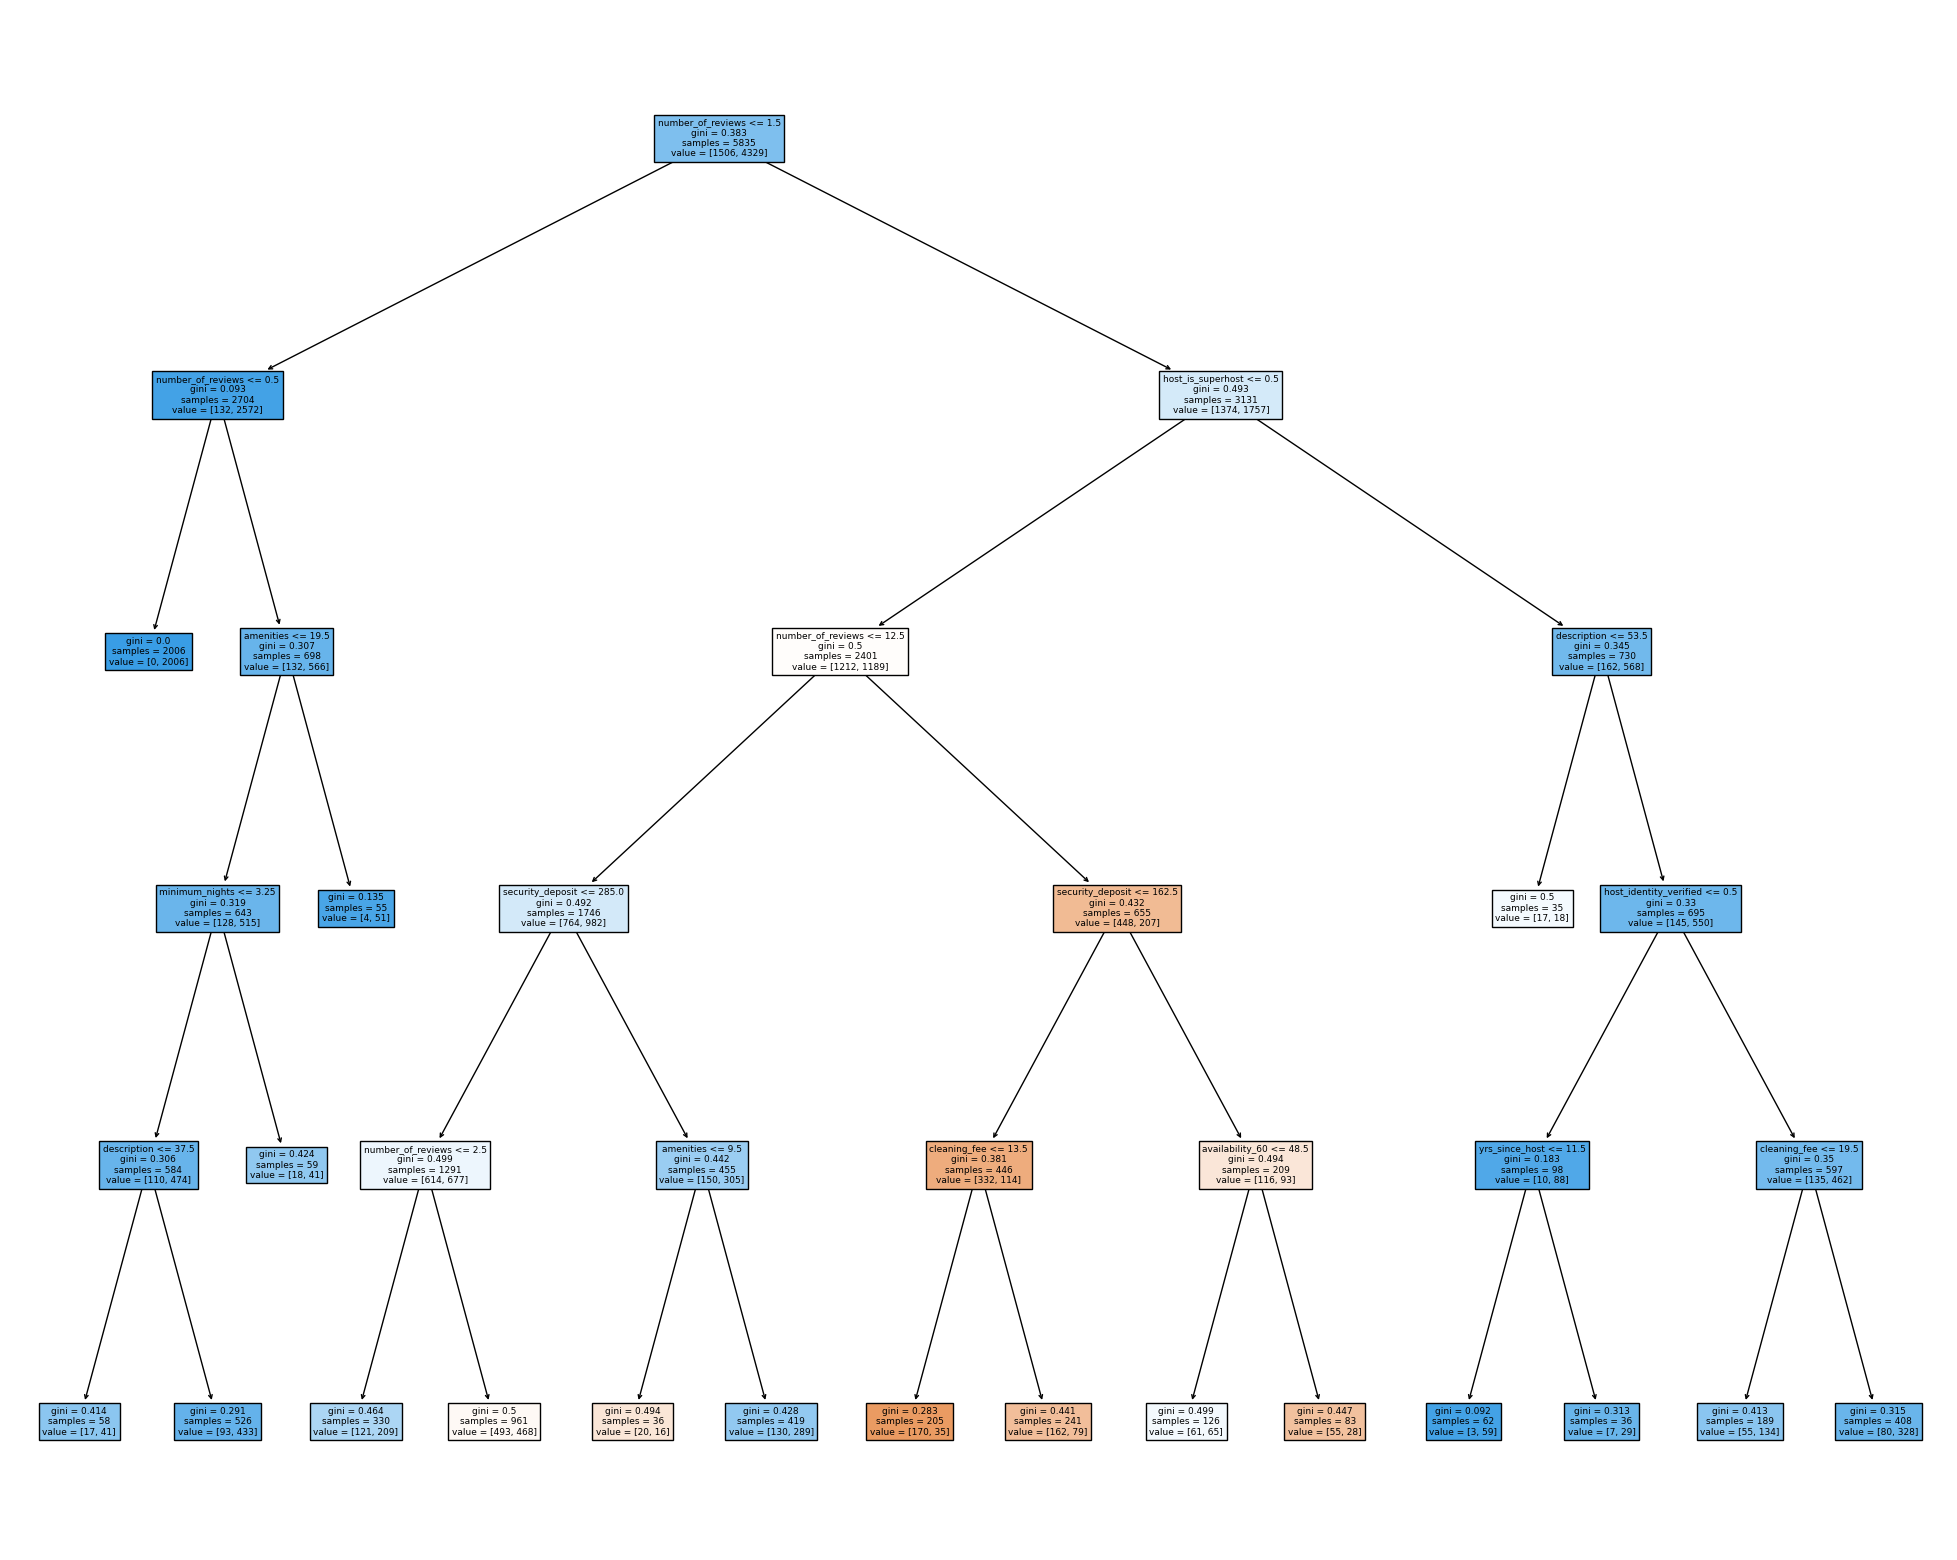

In [143]:
# Visualize the tree 
plt.figure(figsize=(25, 20))
# plot the tree
tree.plot_tree(clf, feature_names=list(x.columns), filled=True)
plt.show()

Based on this tree graph, there are a few findings that we can extract:
- The number of reviews tend to negatively correlated with the rating. It's also interesting to see that there are more than 2000 stays achieve high rating without having a single review, demonstrating by a gini of 0
- Though the number of reviews are negatively correlated with the rating, the number of words are actually positively correlated with the review. By showing sufficient and informative description, it benefit customer greatly in making decision about their stay, leading to higher customer satisfaction. 
- Having high amenities also appears result in higher rating. It's sensible because providing them with several amenities option should potentially fulfil customer's needs

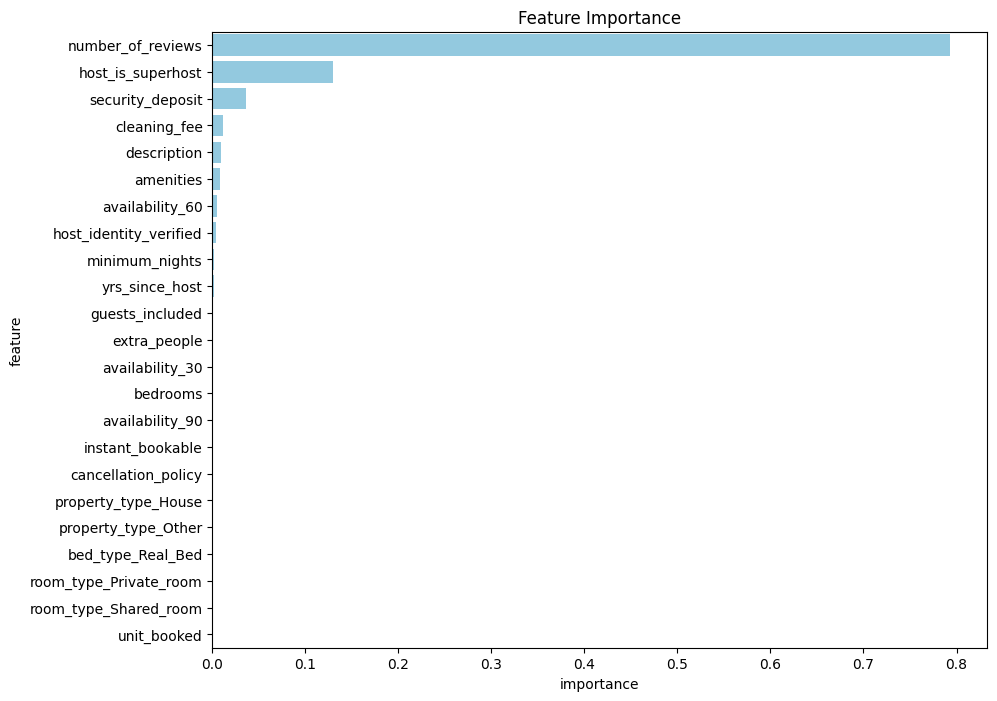

In [144]:
# create a DataFrame with features and importances
df_importances = pd.DataFrame({'feature': x.columns, 'importance': importances})

# sort the DataFrame by importance
df_importances = df_importances.sort_values('importance', ascending=False)

# plot the sorted importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_importances, color = 'skyblue')
plt.title('Feature Importance')
plt.show()

Number of reviews are expected to influence stay's rating. Also being a super host can also help improve the rating significantly. 

### Question 4: Segment the properties into different groups and provide a profile of each segment

In order to segment properties into different groups, I decide to use K-means to generate clusters of properties, then study the characteristics of each group.

In [145]:
# add the price column back to the dataframe
df['price'] = price

# add price to cor_list
cor_list.append('price')


We will employ elbow and silhouette to determine the optimal k for our cluster 

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

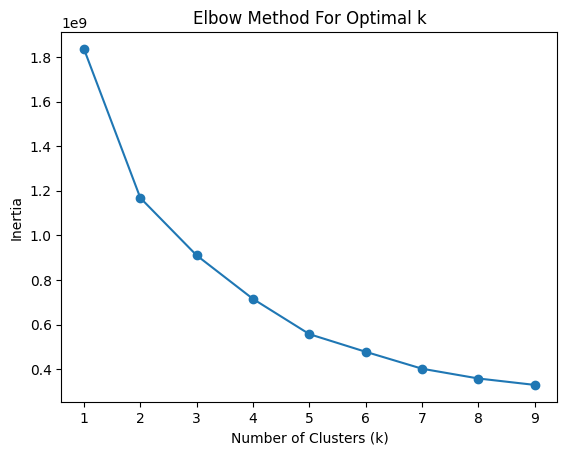

In [146]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# define a range of clusters that you want to test
clusters = range(1, 10)

# list to hold the inertia for each number of clusters
inertia_values = []

for cluster in clusters:
    # fit a KMeans model
    kmeans = KMeans(n_clusters=cluster, random_state=6701)
    kmeans.fit(df)

    # append the model's inertia to our list
    inertia_values.append(kmeans.inertia_)

# plot the inertia values for each number of clusters
plt.plot(clusters, inertia_values, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

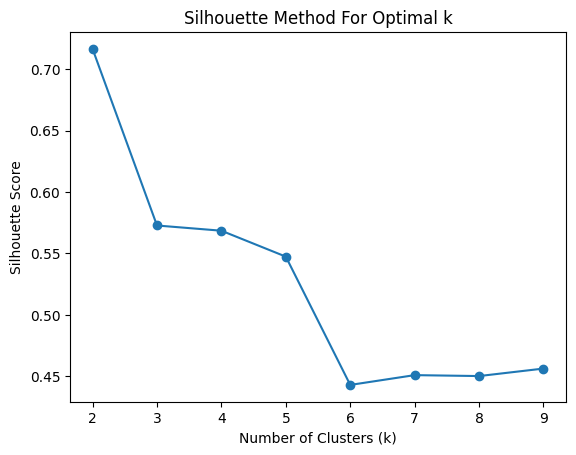

In [147]:
# Apply the silhouette method 
from sklearn.metrics import silhouette_score

# define a range of clusters that I want to test
clusters = range(2, 10)

# list to hold the silhouette scores for each number of clusters
silhouette_scores = []

for cluster in clusters:
    # fit a KMeans model
    kmeans = KMeans(n_clusters=cluster, random_state=6701)
    kmeans.fit(df)

    silhouette_scores.append(silhouette_score(df, kmeans.predict(df)))

# plot the silhouette scores for each number of clusters
plt.plot(clusters, silhouette_scores, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')  
plt.title('Silhouette Method For Optimal k')
plt.show()


Based on both Silhouette and elbow methods, it appers that K=3 is optimal 

In [149]:
# Create a k-means model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=6701)

# fit the model to the data
kmeans.fit(df)

# add the cluster to the data 
df['cluster'] = kmeans.predict(df)


# check the mean of cor variables for each cluster
df.groupby('cluster').mean()[cor_list].T

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brian\AppData\Local\Temp\ipykernel_30544\2007194690.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('cluster').mean()[cor_list].T


cluster,0,1,2
description,132.355408,136.370370,139.120598
bedrooms,1.441042,3.172840,2.692102
amenities,14.001661,16.197531,14.731057
security_deposit,96.666182,2145.283951,544.704376
cleaning_fee,34.410629,183.271605,102.478122
guests_included,1.498443,1.783951,1.966916
extra_people,11.191821,37.283951,23.844184
minimum_nights,1.650301,2.388889,2.120598
availability_30,16.227943,17.604938,17.947705
availability_60,35.548474,35.740741,37.739594


cluster                   0         1         2
host_is_superhost                              
0                  0.849699  0.938272  0.894344
1                  0.150301  0.061728  0.105656


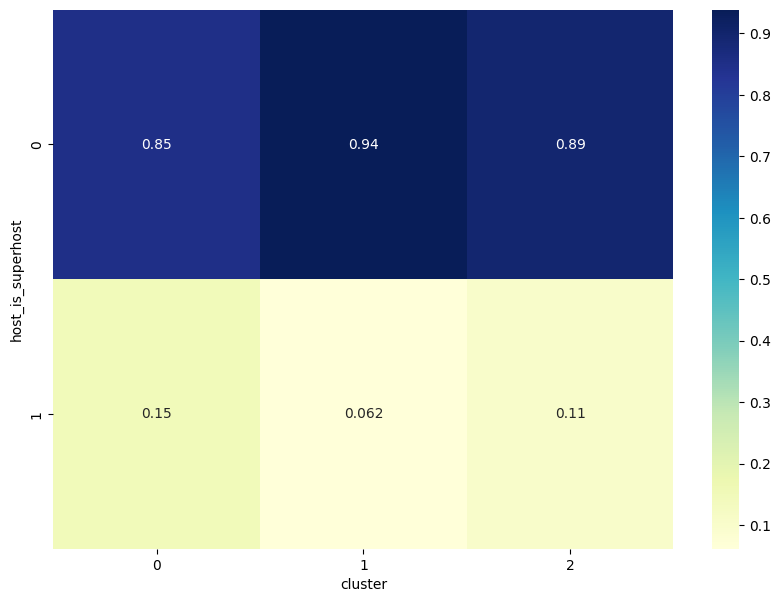



cluster                        0         1         2
host_identity_verified                              
0                       0.320531  0.283951  0.351121
1                       0.679469  0.716049  0.648879


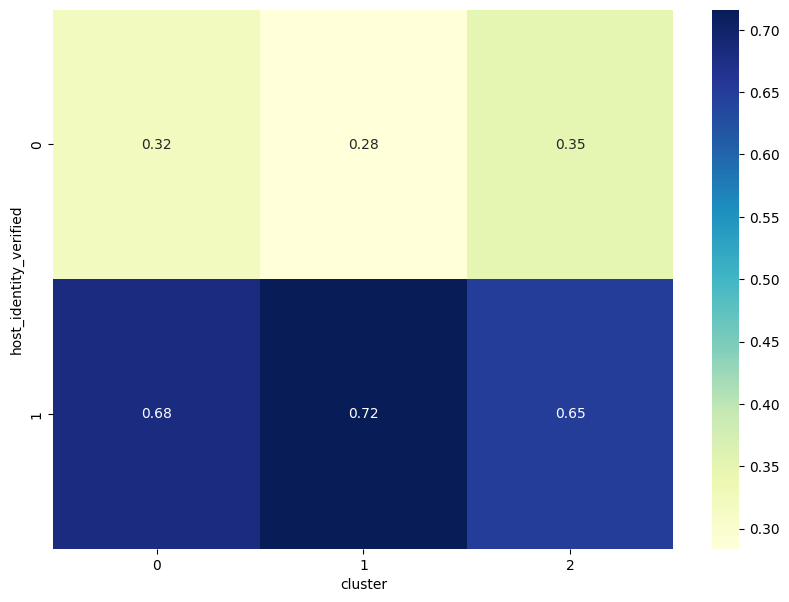



cluster                  0         1         2
instant_bookable                              
0                 0.903052  0.950617  0.944504
1                 0.096948  0.049383  0.055496


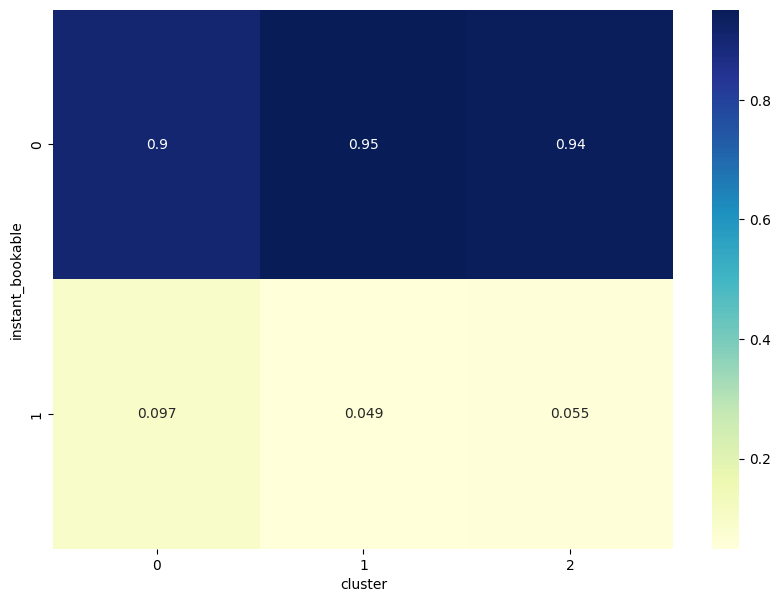



cluster                     0         1         2
property_type_House                              
0                    0.435126  0.061728  0.196371
1                    0.564874  0.938272  0.803629


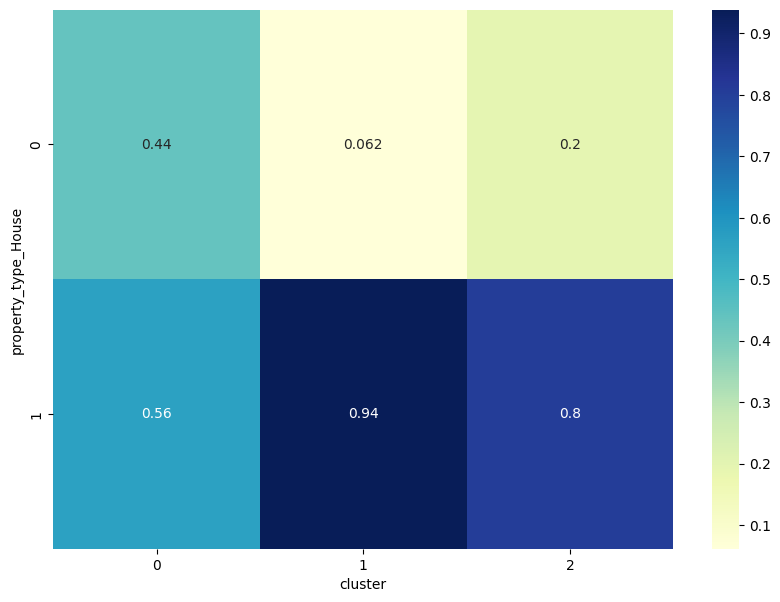



cluster                    0         1         2
property_type_Other                             
0                    0.91966  0.975309  0.956243
1                    0.08034  0.024691  0.043757


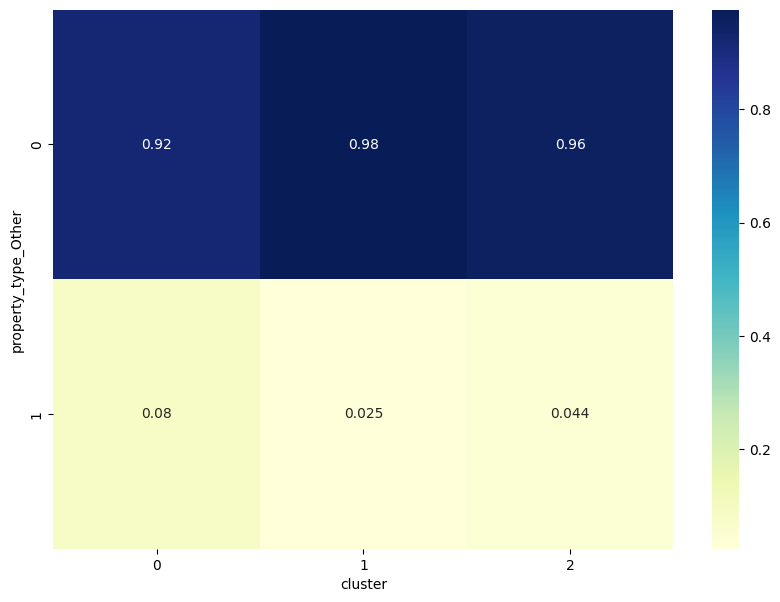



cluster                        0    1        2
room_type_Private_room                        
0                       0.660785  1.0  0.98079
1                       0.339215  0.0  0.01921


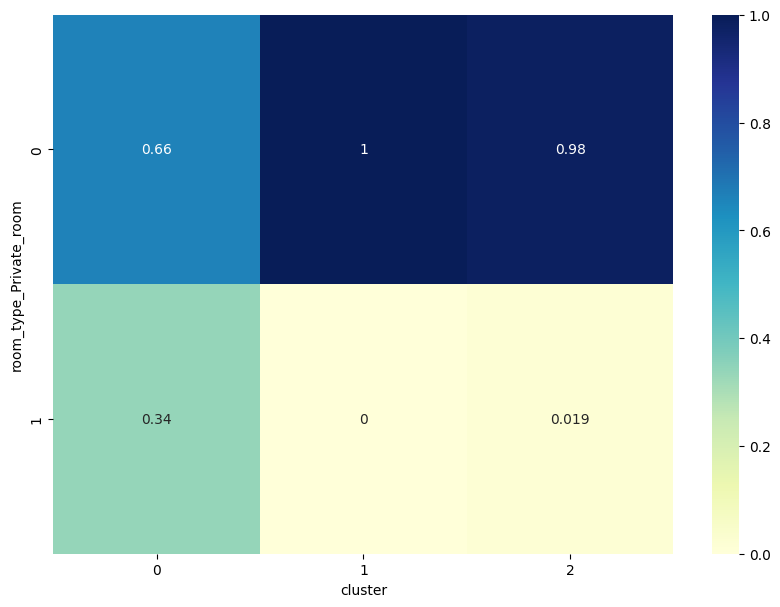



cluster                       0    1         2
room_type_Shared_room                         
0                      0.974881  1.0  0.997866
1                      0.025119  0.0  0.002134


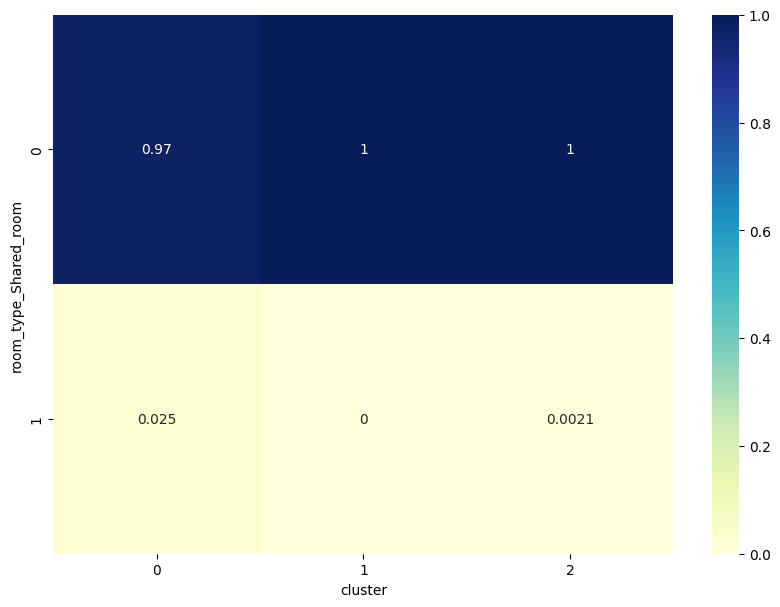



cluster                   0    1         2
bed_type_Real_Bed                         
0                  0.040689  0.0  0.006403
1                  0.959311  1.0  0.993597


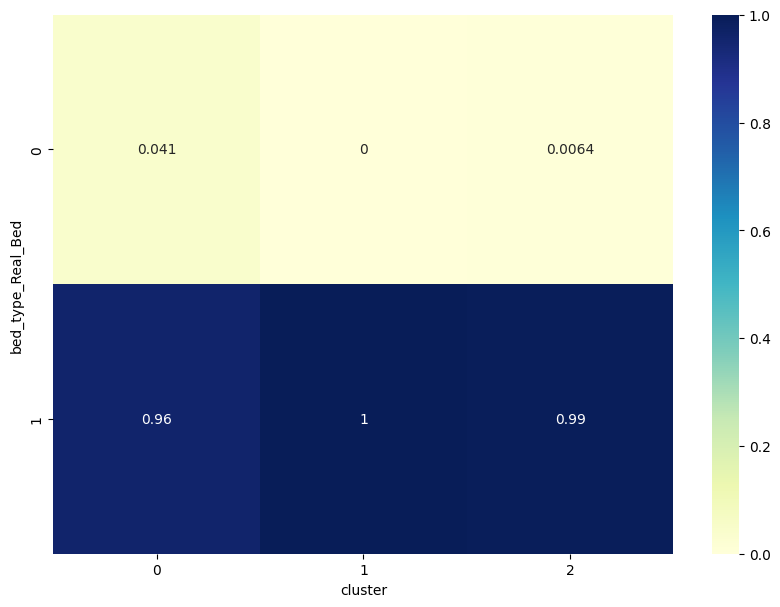



cluster            0         1         2
high_rating                             
0            0.28088  0.111111  0.153682
1            0.71912  0.888889  0.846318


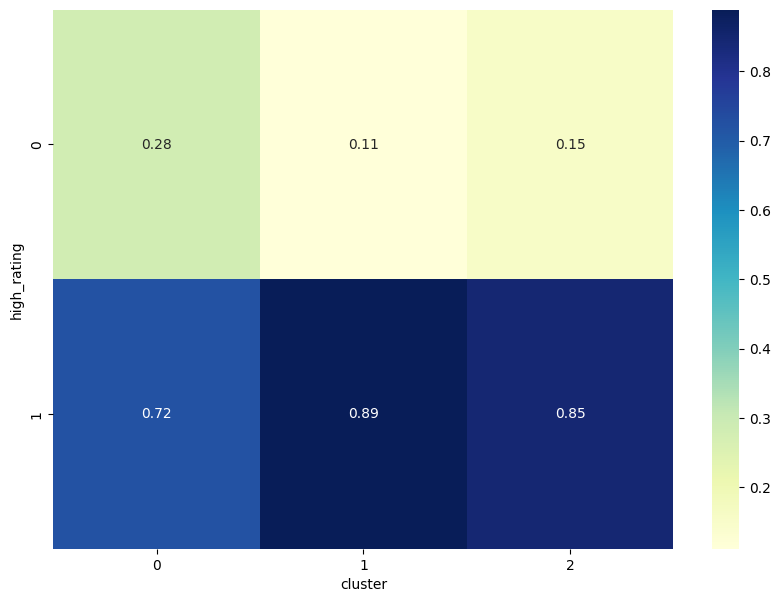



cluster            0         1         2
unit_booked                             
0            0.69317  0.641975  0.690502
1            0.30683  0.358025  0.309498


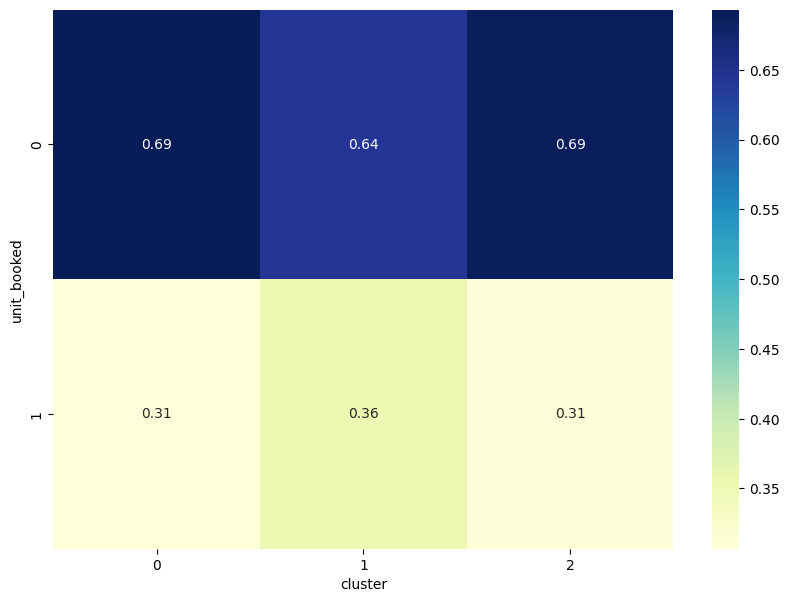

In [150]:
# add unit_booked to binary_features
binary_features.append('unit_booked')

# crosstabt for each cluster for binary variables
for i in binary_features:
    cross_tab = pd.crosstab(df[i], df['cluster'], normalize='columns')
    print(cross_tab)
    # plot the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
    plt.show() 
    print('\n')

In [151]:
# total high_rating for each cluster
df.groupby('cluster').sum()['high_rating']

C:\Users\brian\AppData\Local\Temp\ipykernel_30544\3858439054.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('cluster').sum()['high_rating']


cluster
0    3464
1      72
2     793
Name: high_rating, dtype: int32

In [162]:
# total percent unit_booked for each cluster
df['unit_booked'] = df['unit_booked'].astype(int)
df.groupby('cluster').sum()['unit_booked']/df['unit_booked'].sum()

cluster
0    0.822482
1    0.016138
2    0.161380
Name: unit_booked, dtype: float64

Cluster 0: This cluster is characterized by properties with low security deposits and cleaning fees. It's affordable to include extra guests, and these listings typically have numerous reviews. They offer an easy cancellation policy and, while their ratings aren't the highest, they consistently present the lowest average prices. Therefore, this group of properties have the highest percentage of booked unit compared to other groups. 

Cluster 1: This cluster includes properties with the most bedrooms and the highest cleaning fees. The cost for extra people is also the highest in this group. These listings require longer minimum stays and have stricter cancellation policies. Nearly all hosts in this cluster are recognized as superhosts, and the ratings are the highest among all groups. These properties do not offer private rooms and are generally the most expensive options available.

Cluster 2: Properties in this cluster strike a balance between the features of Clusters 1 and 3. They offer a middle-range option in terms of pricing and amenities, neither the most affordable nor the most expensive.

